In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set_style('darkgrid')

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [108]:
# Importar datos:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='date')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166 entries, 2011-01-31 to 2024-10-31
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fob_urea_kg                       150 non-null    float64
 1   crude_oil_brent_usd_per_bbl       154 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu  154 non-null    float64
 3   coal_australian_usd_per_mt        154 non-null    float64
 4   coal_south_african_usd_per_mt     154 non-null    float64
 5   inflación_mensual                 154 non-null    float64
 6   ipc_diesel                        140 non-null    float64
 7   precipitación_media_mm            156 non-null    float64
 8   temp_media_Celsius                156 non-null    float64
 9   baltic_dry_idx_last               154 non-null    float64
 10  pct_pobreza_rural                 145 non-null    float64
 11  fosfato diamónico 18-46-0         140 non-null    fl

In [109]:
# Renombrar algunas variables:
dict_nombres_fertilizantes = {
        "fosfato diamónico 18-46-0":"pvp_dap",
        "muriato de potasio 0-0-60":"pvp_mop",
        "urea 46-0-0":"pvp_urea"
        }

df = df.rename(columns=dict_nombres_fertilizantes)

# Definir variable objetivo:
variable_objetivo = 'pvp_urea'

# Filtrar variables objetivo no relevantes:
variables_objetivo_no_relevantes = list(dict_nombres_fertilizantes.values())
variables_objetivo_no_relevantes.remove(variable_objetivo)

# Lista de variables que por distintos motivos son excluidas del modelo:
variables_excluidas = ['coal_south_african_usd_per_mt', 'temp_media_Celsius', 'pct_pobreza_rural',
                       'natural_gas_europe_usd_per_mmbtu', 'coal_australian_usd_per_mt', 'inflación_mensual']

# Eliminar variables no relevantes:
df = df.drop(columns=variables_excluidas + variables_objetivo_no_relevantes)


### Análisis Exploratorio de datos

In [110]:
# num_de_filas = ((df.shape[1] + 1) // 2)

# df.plot(
#     subplots=True,
#     layout=(num_de_filas, 2),
#     figsize=(15, 2 * num_de_filas),
#     sharex=False
#     )
# plt.show()

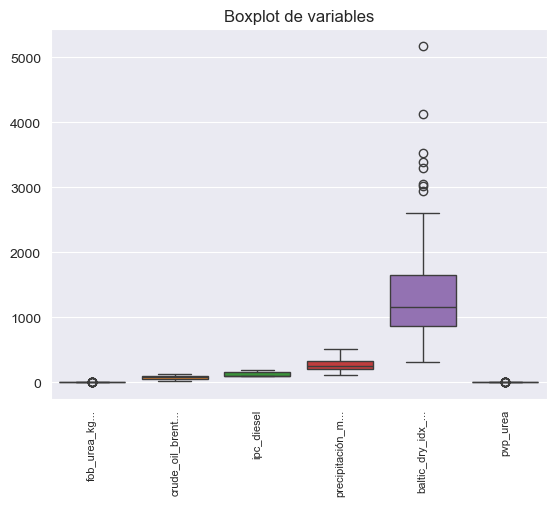

In [111]:
# Crear lista de nombres truncados de variables:
truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in df.columns]
posición_ticks = np.arange(len(df.columns))

# Graficar boxplot de variables originales:
sns.boxplot(df)
plt.xticks(ticks=posición_ticks, labels=truncated_labels, rotation=90, size=8)
plt.title("Boxplot de variables")
plt.show()

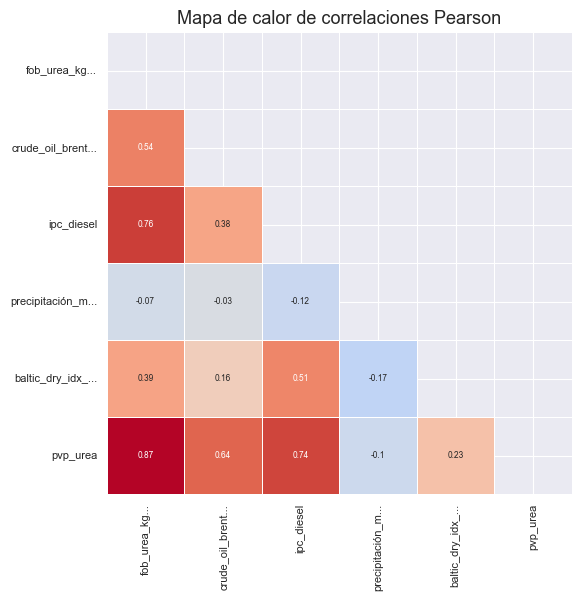

In [112]:
plot_correlation_heatmap(df, method='pearson')

### Ingeniería de variables

In [113]:
# Calcular volatilidad con ventanas de 6 y 12 meses:
ventanas = (6, 12)

for v in ventanas:
    df[f'volatilidad_bdi_{v}m'] = df['baltic_dry_idx_last']\
        .apply(np.log)\
        .diff()\
        .rolling(window=v)\
        .std()

# Interacción crudo europeo - BDI:
df['inter_bdi_crude'] = df['baltic_dry_idx_last'] * df['crude_oil_brent_usd_per_bbl']

In [114]:
# Calcular coeficiente de variación de precipitación para diferentes ventanas.
# El coeficiente de variación es una medida de la variabilidad relativa de una serie en relación con su media.

ventanas = (12, 18) # 3 y 6 son estacionarias ergo exógenas y no tienen impacto.

for v in ventanas:
    df[f'coef_var_precip_{v}m'] = df['precipitación_media_mm'].rolling(window=v).std() \
        / df['precipitación_media_mm'].rolling(window=v).mean()

#### Transformación log de variables:

In [115]:
# Crear un DataFrame sin NaN:
df_sin_na = df.dropna()

# Crear DataFrame para variables logarítmicas:
ln_data = pd.DataFrame(index=df_sin_na.index)

# Variables porcentuales:
variables_no_log_transformables = ['inflación_mensual', 'pct_pobreza_rural', 'var_pct_pobreza_rural', 'coef_var_pobreza_rural',
                                   'precipitación_media_m', 'precipitación_media_m2', 'coef_var_precip_12m', 'coef_var_precip_18m',
                                   'coef_var_precip_24m', 'volatilidad_bdi_3m', 'volatilidad_bdi_6m', 'volatilidad_bdi_12m']

variables_log_transformadas = []

# Transformación logarítmica de las variables:
for col in df_sin_na.columns:
    
    # Transformación logarítmica de las variables no transformables:
    if col not in variables_no_log_transformables:
        
        # Añadir a lista de variables log-transformadas:
        variables_log_transformadas.append(col)
        
        # Transformar:
        ln_data['ln_' + col] = df_sin_na[col].apply(np.log)
    else:
        ln_data[col] = df_sin_na[col]

### EDA post ingeniería de variables

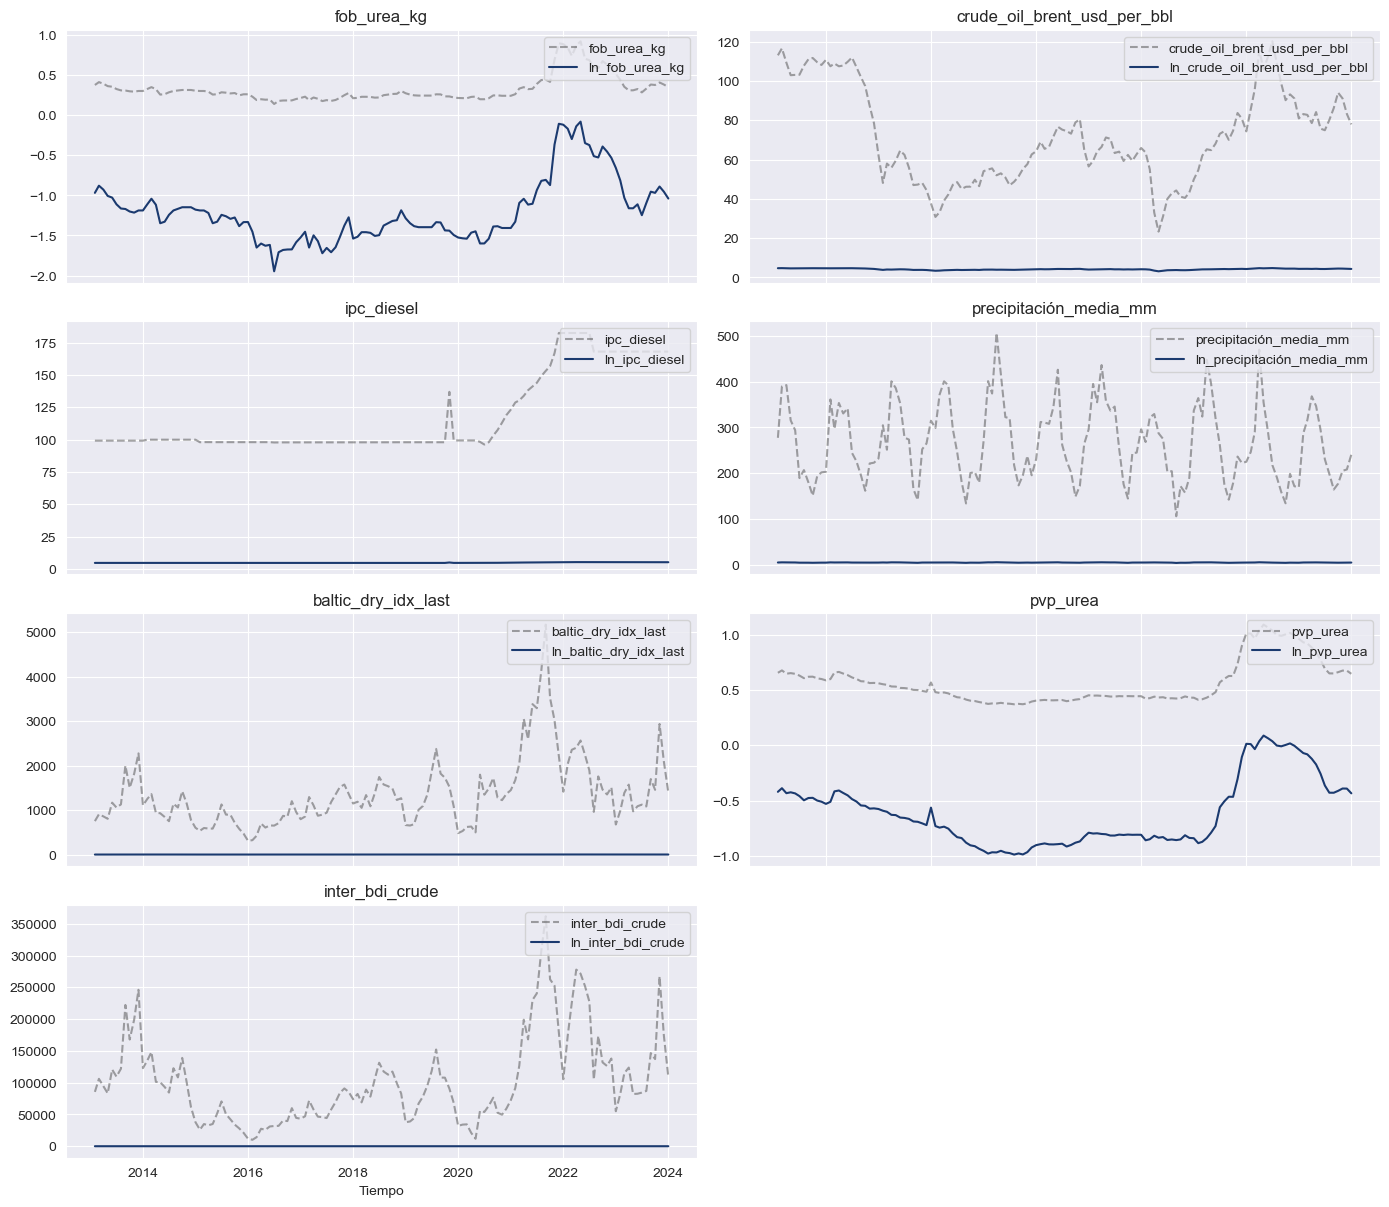

In [116]:
# Crar un DataFrame que solo contenga variables con tranformación log:
df_variables_log_transformadas = ln_data[["ln_" + col for col in variables_log_transformadas]]

# Renombrar variables a sus denominaciones originales para lograr empates en gráfico:
df_variables_log_transformadas.columns = variables_log_transformadas

# Comparar forma original de las variables y su transformación log:
plot_comparison(df_sin_na[variables_log_transformadas], df_variables_log_transformadas, prefix='ln_')

In [117]:
# Variable objetivo:
variable_objetivo = "ln_pvp_urea"

# Variables excluidas en segunda instancia:
variables_excluidas_2 = ['ln_baltic_dry_idx_last', 'ln_precipitación_media_mm', 'coef_var_precip_18m', 'volatilidad_bdi_12m'] # 'coef_var_precip_12m'
ln_data = ln_data.drop(columns=variables_excluidas_2)

# Extraer variables predictoras:
X = ln_data.drop(columns=variable_objetivo)

# Extraer variable objetivo:
y = ln_data[variable_objetivo]

In [118]:
# Calcular el factor de inflación de varianza (VIF) de las variables explicativas originales:
calcular_vif(X)

,Variable,VIF
0,ln_fob_urea_kg,3.927598
1,ln_ipc_diesel,3.670065
2,ln_inter_bdi_crude,3.018541
3,ln_crude_oil_brent_usd_per_bbl,3.010859
4,coef_var_precip_12m,1.447890
5,volatilidad_bdi_6m,1.215060


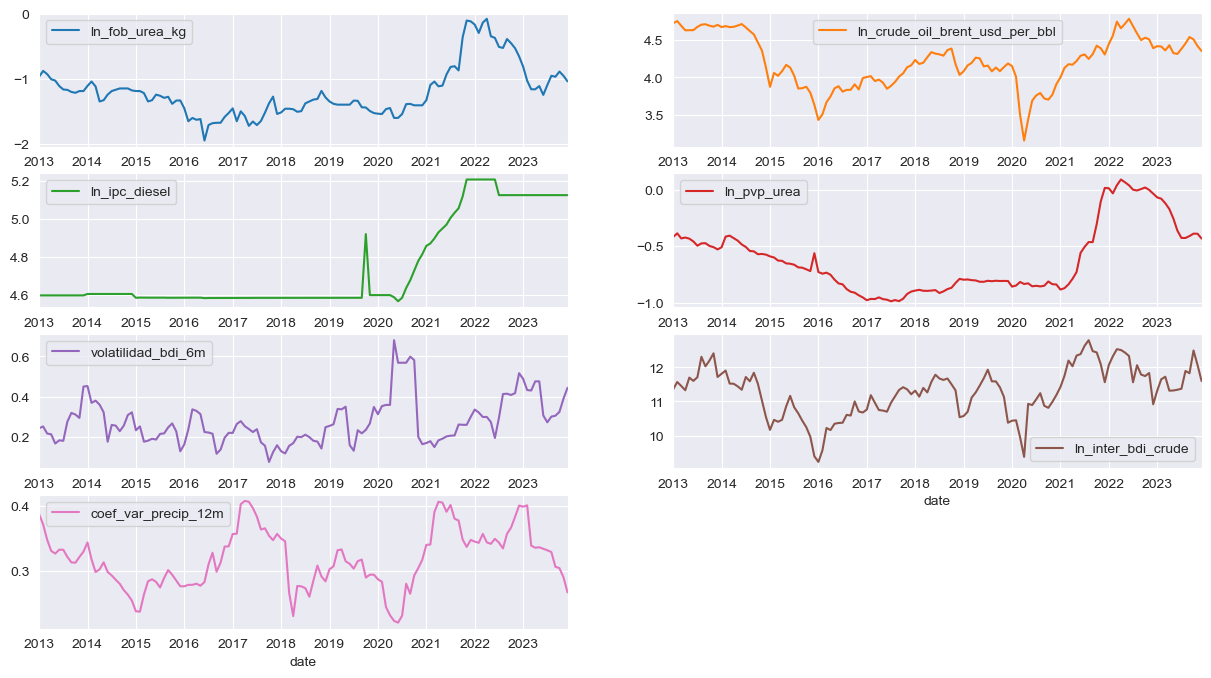

In [119]:
num_de_filas = ((ln_data.shape[1] + 1) // 2)

# Revisar variables tras transformaciones:
ln_data.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

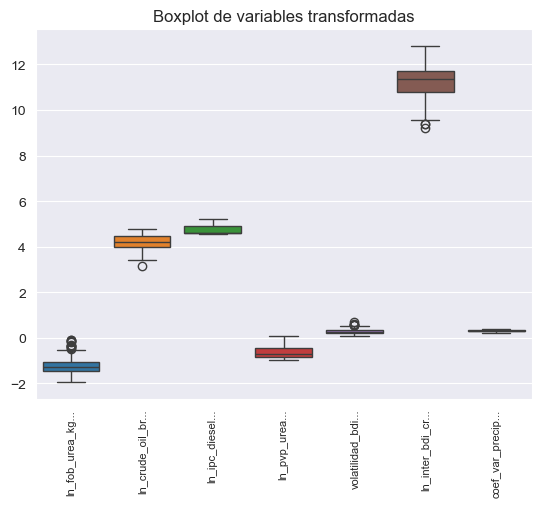

In [120]:
truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in ln_data.columns]
posición_ticks = np.arange(len(ln_data.columns))

sns.boxplot(ln_data)
plt.xticks(ticks=posición_ticks, labels=truncated_labels, rotation=90, size=8)
plt.title("Boxplot de variables transformadas")
plt.show()

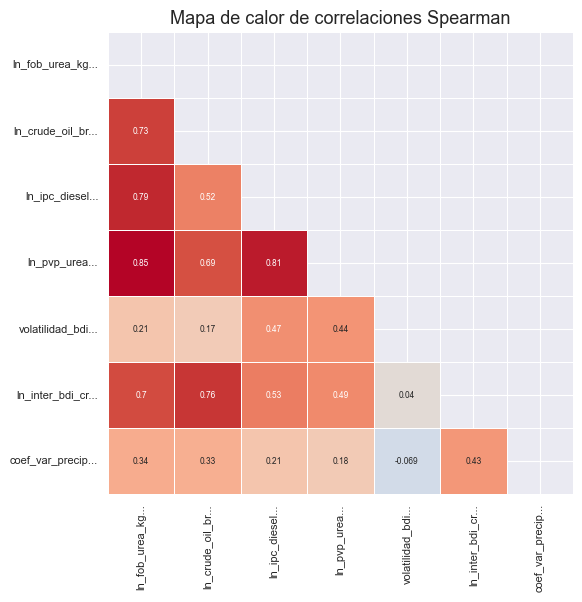

In [121]:
plot_correlation_heatmap(ln_data, method='spearman')

### División de datos

In [176]:
# Definir períodos de entrenamiento y prueba:
año_fin_train = "2022"
año_inicio_test = "2023"

# Dividir datos por temporalidad:
df_train = ln_data[:año_fin_train]
df_test = ln_data[año_inicio_test:]

# Revisar proporción test/train:
print("Proporción test/train: ", round(df_test.shape[0] / df_train.shape[0], 2))

Proporción test/train:  0.1


## VECM

### Revisar VIF de variables para VECM

In [177]:
# plot_scatter_matrix(df_train) #, trendline=True)

### Primer supuesto VECM: variables son no estacionarias en niveles (forma original)

In [178]:
# Revisar si las variables son no estacionarias bajo supuesto del modelo VECM:
evaluar_estacionareidad_vars = evaluar_estacionareidad(df_train)

evaluar_estacionareidad_vars

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg,0.225959,0.028133,False,True,No estacionario
1,ln_crude_oil_brent_usd_per_bbl,0.241034,0.100000,False,False,No claro
2,ln_ipc_diesel,0.980369,0.010000,False,True,No estacionario
3,ln_pvp_urea,0.466478,0.074284,False,False,No claro
4,volatilidad_bdi_6m,0.108375,0.100000,False,False,No claro
5,ln_inter_bdi_crude,0.116916,0.085969,False,False,No claro
6,coef_var_precip_12m,0.403498,0.100000,False,False,No claro


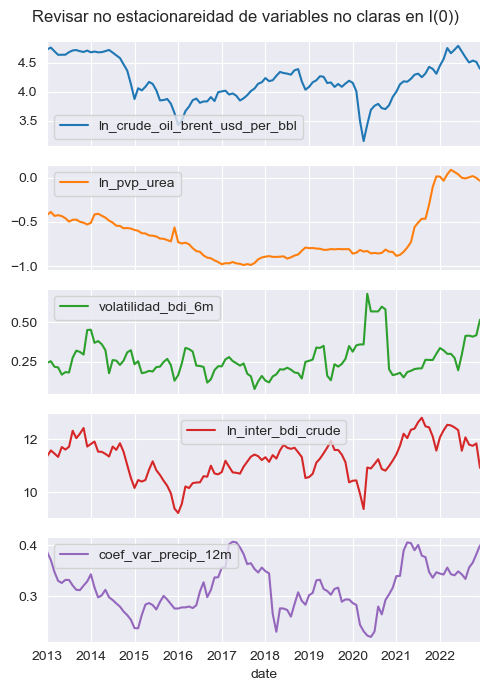

In [179]:
# Filtrar variables con estacionareidad no clara:
estacionareidad_no_clara = df_train[evaluar_estacionareidad_vars.query("estado_estacionario == 'No claro'")['variable']]

# Revisar no estacionareidad visualmente:
estacionareidad_no_clara.plot(subplots=True, figsize=(5, 7))
plt.suptitle("Revisar no estacionareidad de variables no claras en I(0))")
plt.tight_layout()
plt.show()

In [180]:
# Definir todas las variables como no estacionarias:
evaluar_estacionareidad_vars['estado_estacionario'] = "No estacionario"

**Conclusión 1:** A pesar de que en niveles existen variables con resultado de estacionareidad "no claro", visualmente existe un grado alto de plausibilidad de que estas variables son no estacionarias.

### Segundo supuesto VECM: las variables son estacionarias tras I(1)

In [181]:
# Obtener lista de variables no estacionarias:
variables_no_estacionarias = evaluar_estacionareidad_vars.query("estado_estacionario != 'Estacionario'")['variable'].tolist()

df_diferenciación_I1 = df_train[variables_no_estacionarias]\
    .diff()\
    .dropna()\
    .add_suffix("_d1")

# Evaluar si las variables no estacionarias se convierten tras primera diferenciación:
evaluar_estacionareidad_vars_I1 = evaluar_estacionareidad(df_diferenciación_I1)

evaluar_estacionareidad_vars_I1


,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg_d1,9.620901e-02,0.100000,False,False,No claro
1,ln_crude_oil_brent_usd_per_bbl_d1,3.952880e-12,0.100000,True,False,Estacionario
2,ln_ipc_diesel_d1,2.681431e-28,0.100000,True,False,Estacionario
3,ln_pvp_urea_d1,7.091430e-02,0.021813,False,True,No estacionario
4,volatilidad_bdi_6m_d1,2.723341e-08,0.100000,True,False,Estacionario
5,ln_inter_bdi_crude_d1,8.759703e-19,0.100000,True,False,Estacionario
6,coef_var_precip_12m_d1,7.624117e-05,0.100000,True,False,Estacionario


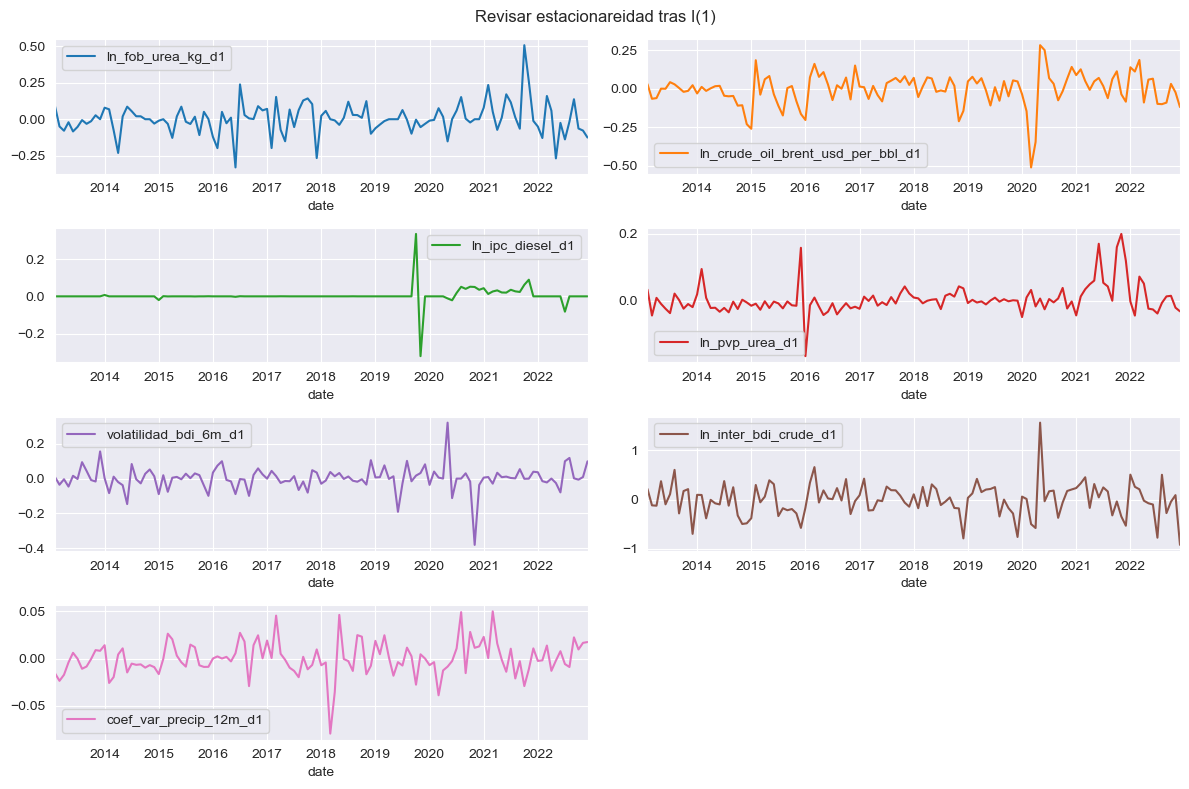

In [182]:
num_de_filas = ((df_diferenciación_I1.shape[1] + 1) // 2)

df_diferenciación_I1.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(12, 2 * num_de_filas),
    sharex=False
    )
plt.suptitle("Revisar estacionareidad tras I(1)")
plt.tight_layout()
plt.show()

**Conclusión:** Aunque algunos resultados de estacionareidad tras I(1) por KPSS y ADF aparecen como "no claros", las gráficas sugieren con alto grado de plausibilidad que todas las variables son estacionarias. Por tanto, se cumple el segundo supuesto del modelo VECM.

### Ruptura estructural

In [183]:
# Crear dataframe solamente con variables no estacionarias:
df_endógenas = df_train[variables_no_estacionarias]

# Crear dataframe de variables exógenas al modelo de cointegración (en este caso, las variables estacionarias):
set_vars_exógenas = set(df_train.columns) - set(variables_no_estacionarias)
df_exógenas_vecm = df_train[list(set_vars_exógenas)]

# # Eliminar las variables fertilizantes que no son de interés: 
# columns_to_drop = [col for col in lista_fertilizantes if col != variable_objetivo]

# df_endógenas = df_no_estacionarias.drop(columns=columns_to_drop)

print("Variables seleccionadas como exógenas al ser estacionarias: ", set_vars_exógenas)

Variables seleccionadas como exógenas al ser estacionarias:  set()


In [184]:
# Dividir en variable dependiente e independientes
y_train = df_endógenas[variable_objetivo]
X_train = df_endógenas.drop(columns=[variable_objetivo])

# Detectar rupturas estructurales
ruptura_estructural = detect_structural_breaks(y_train, X_train, model_type="rbf", n_bkps=3)

# Mostrar resultados
print(ruptura_estructural)

  break_date  F-Statistic       p-value
0 2014-09-30    23.716490  3.693903e-06
1 2017-08-31    52.641073  5.575384e-11
2 2021-05-31    13.710608  3.326255e-04


In [185]:
# Crear DataFrame vacío con el mismo índice que df_endógenas:
dummies_ruptura = pd.DataFrame(index=df_endógenas.index)

# Ordenar las fechas de ruptura
fechas_ruptura = sorted(pd.to_datetime(ruptura_estructural['break_date'].values))

# Iterar sobre las fechas de ruptura, manejando intervalos entre rupturas
for i, fecha in enumerate(fechas_ruptura):
    # Formatear la fecha para el nombre de la columna
    str_fecha = fecha.strftime('%b%Y').replace(".", "_")
    
    # Definir el fin del intervalo como la siguiente fecha de ruptura o el final del índice
    if i < len(fechas_ruptura) - 1:
        fin_intervalo = fechas_ruptura[i + 1]
    else:
        fin_intervalo = dummies_ruptura.index.max() + pd.Timedelta(days=1)  # Asegura incluir el último día
    
    # Crear la dummy para el intervalo actual
    dummies_ruptura['ruptura_' + str_fecha] = (
        (dummies_ruptura.index >= fecha) & (dummies_ruptura.index < fin_intervalo)
    ).astype(int)

# Unir variables dummy al DataFrame de variables exógenas:
df_exógenas_vecm = df_exógenas_vecm.join(dummies_ruptura, how="inner").add_prefix('exog_')

df_exógenas_vecm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2013-01-31 to 2022-12-31
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   exog_ruptura_sep_2014  120 non-null    int32
 1   exog_ruptura_ago_2017  120 non-null    int32
 2   exog_ruptura_may_2021  120 non-null    int32
dtypes: int32(3)
memory usage: 2.3 KB


In [186]:
# df_completo = df_endógenas.join(df_exógenas_vecm, how='inner')

# df_completo.to_excel("data/df_completo.xlsx", index=True)

In [187]:
df_ols_previo = df_endógenas.join(df_exógenas_vecm, how='inner')
X_ols = df_ols_previo.drop(columns=variable_objetivo)
y_ols = df_ols_previo[variable_objetivo]

# Selección automática de variables significativas:
modelo_ols_significativo, variables_significativas_ols = ols_backward_elimination(X_ols, y_ols, significance_level=0.05)

print(modelo_ols_significativo.summary())

variable eliminada: exog_ruptura_may_2021; p-valor: 0.4754
                            OLS Regression Results                            
Dep. Variable:            ln_pvp_urea   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     338.6
Date:               ma., 10 dic. 2024   Prob (F-statistic):           3.02e-74
Time:                        15:05:41   Log-Likelihood:                 171.35
No. Observations:                 120   AIC:                            -324.7
Df Residuals:                     111   BIC:                            -299.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### Cointegración

El **Vector AutoRegresivo** (VAR) es un modelo econométrico que captura las relaciones dinámicas entre varias series temporales tratándolas como variables endógenas. A diferencia de modelos univariados, el VAR permite que cada variable dependa de sus propios rezagos y de los rezagos de las demás, sin suponer relaciones causales específicas. Esto lo hace útil para analizar cómo los cambios en una variable afectan a las demás a lo largo del tiempo. Es ideal para identificar patrones de interdependencia y realizar análisis de impacto como impulso-respuesta o descomposición de varianza.

In [188]:
from statsmodels.tsa.api import VAR

# Ajusta un modelo VAR preliminar
modelo_var = VAR(df_endógenas, freq='ME', exog=df_exógenas_vecm)
orden_rezagos = modelo_var.select_order(maxlags=6) # 6 es más consistente
print(orden_rezagos.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -30.63      -29.96   4.976e-14      -30.36
1     -38.09*     -36.24*  2.885e-17*     -37.34*
2      -37.99      -34.97   3.232e-17      -36.76
3      -37.78      -33.58   4.104e-17      -36.08
4      -37.51      -32.13   5.726e-17      -35.33
5      -37.53      -30.98   6.153e-17      -34.87
6      -37.66      -29.93   6.208e-17      -34.52
-------------------------------------------------


In [189]:
# Obtener el valor de lags óptimo según HQIC:
criterio = 'fpe'
maxlags_óptimo = 6 # orden_rezagos.selected_orders[criterio]

print(f"Número de lags óptimo según criterio {criterio.upper()}: ", maxlags_óptimo)

Número de lags óptimo según criterio FPE:  6


La **prueba de Johansen** es un método econométrico utilizado para identificar relaciones de equilibrio a largo plazo (cointegración) entre múltiples series temporales no estacionarias. A diferencia de otros enfoques, como *Engle-Granger*, permite analizar más de dos variables simultáneamente. La prueba utiliza un modelo VAR para evaluar si existe una combinación lineal estacionaria entre las series. Sus resultados indican cuántos vectores de cointegración existen, lo que ayuda a decidir si las variables tienen una relación estable a largo plazo y si se debe utilizar un modelo como el VECM para capturar dichas dinámicas.

In [190]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

cointegración_johansen = coint_johansen(df_endógenas, det_order=0, k_ar_diff=maxlags_óptimo)

estadísticos_de_traza = cointegración_johansen.lr1
valores_críticos = cointegración_johansen.cvt

print("Estadísticos de traza:\n", estadísticos_de_traza)
print("Valores críticos:\n[1% | 5% | 10%]\n", valores_críticos)

Estadísticos de traza:
 [176.4480275  110.4633598   66.16049567  35.0973356   12.87142034
   5.34797712   0.18626037]
Valores críticos:
[1% | 5% | 10%]
 [[120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [191]:
# Extraer columna del 5% de nivel de confianza:
valores_críticos_5_pct = valores_críticos[:, 1]  

# Establecer vectores de cointegración base r=0:
r = 0

# Determinar r automáticamente:
for i, (trace, critical) in enumerate(zip(estadísticos_de_traza, valores_críticos_5_pct)):
    if trace > critical:
        # Incrementar r si se rechaza la hipótesis nula:
        r = i + 1

print(f"Número de vectores de cointegración (r): {r}")

Número de vectores de cointegración (r): 2


In [192]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Ajustar el modelo VECM
modelo_vecm = VECM(
    df_endógenas,
    exog=df_exógenas_vecm, # Variables estacionarias
    k_ar_diff=maxlags_óptimo,  # Número de rezagos diferenciales basado en el VAR
    coint_rank=r,  # Número de vectores de cointegración, según Johansen
    deterministic='ci',
    freq='ME'
    ).fit()

# Resumen del modelo
print(modelo_vecm.summary())

    Det. terms outside the coint. relation & lagged endog. parameters for equation ln_fob_urea_kg    
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
exog1                                -0.0523      0.029     -1.826      0.068      -0.108       0.004
exog2                                -0.0290      0.024     -1.183      0.237      -0.077       0.019
exog3                                 0.1846      0.068      2.713      0.007       0.051       0.318
L1.ln_fob_urea_kg                    -0.0279      0.107     -0.260      0.795      -0.238       0.182
L1.ln_crude_oil_brent_usd_per_bbl     0.2664      0.151      1.770      0.077      -0.029       0.561
L1.ln_ipc_diesel                      0.7185      0.237      3.036      0.002       0.255       1.182
L1.ln_pvp_urea                       -0.4246      0.306     -1.389      0.165     

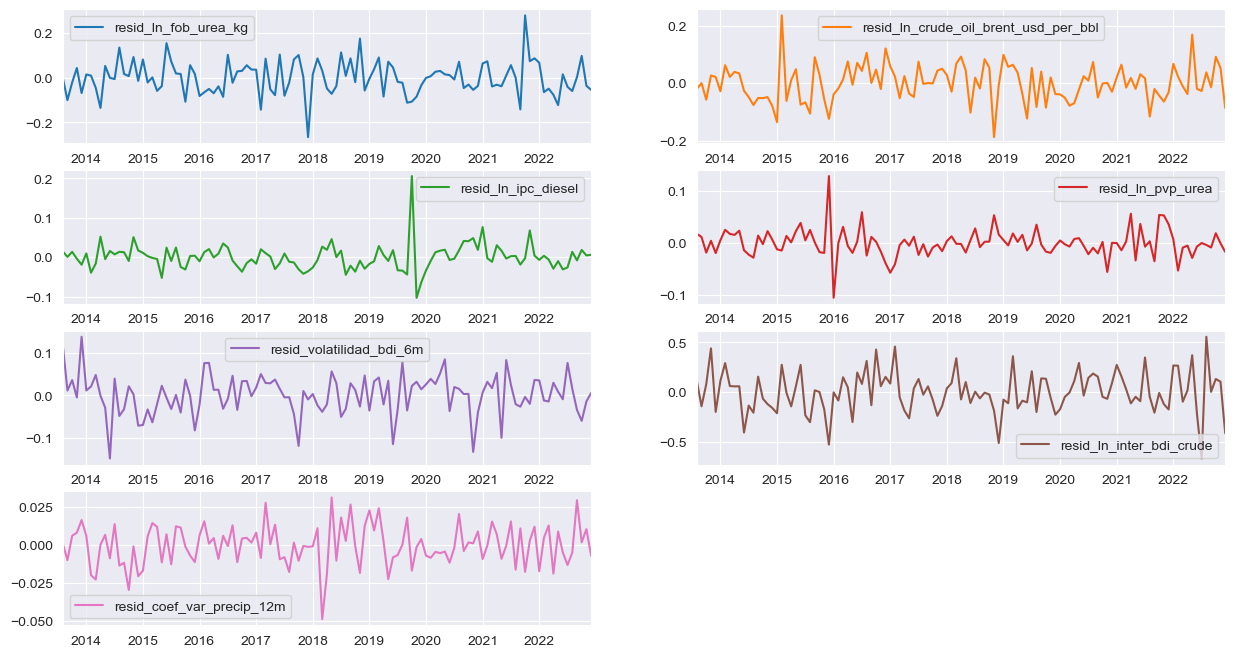

In [193]:
residuos_vecm = pd.DataFrame()

for var_name, resid in zip(df_endógenas.columns, modelo_vecm.resid.T):
    residuos_vecm["resid_" + var_name] = resid


residuos_vecm.index = pd.date_range(
    start=df_endógenas.index.min() + pd.DateOffset(months=maxlags_óptimo + 1),
    end=df_endógenas.index.max(),
    freq='ME'
    ) 


num_de_filas = ((residuos_vecm.shape[1] + 1) // 2)

residuos_vecm.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

En un modelo VECM, la estacionariedad de los residuos es esencial para garantizar que las relaciones entre las variables estén correctamente especificadas y que el modelo no omita dinámicas importantes. Si los residuos no son estacionarios, esto podría indicar la presencia de patrones no capturados, como tendencias o ciclos, lo que comprometería la validez de las inferencias realizadas. Además, la estacionariedad previene problemas como las relaciones espurias, asegurando que las estimaciones reflejen vínculos económicos reales y no coincidencias estadísticas.

La evaluación conjunta de estacionariedad mediante las pruebas **Augmented Dickey-Fuller** (ADF) y **Kwiatkowski-Phillips-Schmidt-Shin** (KPSS) permite obtener una perspectiva más completa sobre la naturaleza de las series temporales. Estas pruebas abordan la estacionariedad desde enfoques opuestos: ADF detecta la presencia de raíces unitarias (es decir, no estacionariedad) asumiendo como hipótesis nula que la serie no es estacionaria, mientras que KPSS evalúa si existe tendencia o estructura no estacionaria, partiendo de la hipótesis nula de que la serie es estacionaria.

La combinación de ambos resultados facilita una evaluación robusta de la estacionareidad de los residuos. Una serie se considera estacionaria si ADF rechaza su hipótesis nula (p-valor bajo) y KPSS no la rechaza (p-valor alto). Por el contrario, se considera no estacionaria si ADF no rechaza su hipótesis nula (p-valor alto) o KPSS sí la rechaza (p-valor bajo). Este enfoque evita depender únicamente de un test, aumentando la precisión y confiabilidad del análisis.

In [194]:
# Evaluar estacionareidad de residuos del modelo VECM utilizando ADF y KPSS:
evaluar_estacionareidad_residuos_vecm = evaluar_estacionareidad(residuos_vecm)

evaluar_estacionareidad_residuos_vecm

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,resid_ln_fob_urea_kg,8.678729e-19,0.1,True,False,Estacionario
1,resid_ln_crude_oil_brent_usd_per_bbl,1.234933e-18,0.1,True,False,Estacionario
2,resid_ln_ipc_diesel,3.408877e-19,0.1,True,False,Estacionario
3,resid_ln_pvp_urea,2.399343e-21,0.1,True,False,Estacionario
4,resid_volatilidad_bdi_6m,1.384815e-17,0.1,True,False,Estacionario
5,resid_ln_inter_bdi_crude,1.317724e-18,0.1,True,False,Estacionario
6,resid_coef_var_precip_12m,7.643481e-20,0.1,True,False,Estacionario


La **prueba de Ljung-Box** evalúa si los residuos de un modelo de series temporales son independientes, es decir, si no presentan autocorrelación. La independencia de los residuos garantiza que el modelo haya capturado adecuadamente las dinámicas de las variables y no existan patrones no modelados.

La hipótesis nula de la prueba plantea que no hay autocorrelación en los residuos, mientras que la hipótesis alternativa sugiere lo contrario. Un p-valor alto indica que los residuos son independientes, mientras que un p-valor bajo señala la presencia de autocorrelación y la posible necesidad de ajustar el modelo.

En modelos como el VECM, la prueba de Ljung-Box es clave para confirmar que las relaciones temporales han sido correctamente especificadas y que las inferencias basadas en el modelo son confiables.

In [195]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Crear una lista para almacenar los resultados
resultados_ljung_box = []

# Iterar sobre cada columna (variable) del DataFrame de residuos
for column in residuos_vecm.columns:
    # Ejecutar la prueba de Ljung-Box
    ljung_box = acorr_ljungbox(residuos_vecm[column], lags=10, return_df=True)  # lags = número de retardos
    
    # Extraer los resultados finales (último lag)
    lb_stat = ljung_box['lb_stat'].iloc[-1]
    lb_pvalue = ljung_box['lb_pvalue'].iloc[-1]
    
    # Veredicto: Si p-valor > 0.05, no hay autocorrelación (residuos son aleatorios)
    veredicto = "Sin autocorrelación" if lb_pvalue > 0.05 else "Autocorrelación presente"
    
    # Agregar los resultados a la lista
    resultados_ljung_box.append({
        "variable": column,
        "lb_stat": lb_stat,
        "lb_pvalue": lb_pvalue,
        "veredicto": veredicto
    })

# Convertir los resultados en un DataFrame
df_ljung_box = pd.DataFrame(resultados_ljung_box)

# Mostrar el DataFrame
df_ljung_box



,variable,lb_stat,lb_pvalue,veredicto
0,resid_ln_fob_urea_kg,9.325374,0.501528,Sin autocorrelación
1,resid_ln_crude_oil_brent_usd_per_bbl,2.017761,0.996202,Sin autocorrelación
2,resid_ln_ipc_diesel,3.569431,0.964688,Sin autocorrelación
3,resid_ln_pvp_urea,7.467925,0.680654,Sin autocorrelación
4,resid_volatilidad_bdi_6m,5.153843,0.880667,Sin autocorrelación
5,resid_ln_inter_bdi_crude,5.595851,0.847999,Sin autocorrelación
6,resid_coef_var_precip_12m,8.402623,0.589572,Sin autocorrelación


#### Homocedasticidad de residuos

In [196]:
for col in residuos_vecm.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(residuos_vecm[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:

resid_ln_fob_urea_kg ->  p-value: 0.551
resid_ln_crude_oil_brent_usd_per_bbl ->  p-value: 0.531
resid_ln_ipc_diesel ->  p-value: 0.378
resid_ln_pvp_urea ->  p-value: 0.561
resid_volatilidad_bdi_6m ->  p-value: 0.185
resid_ln_inter_bdi_crude ->  p-value: 0.354
resid_coef_var_precip_12m ->  p-value: 0.926


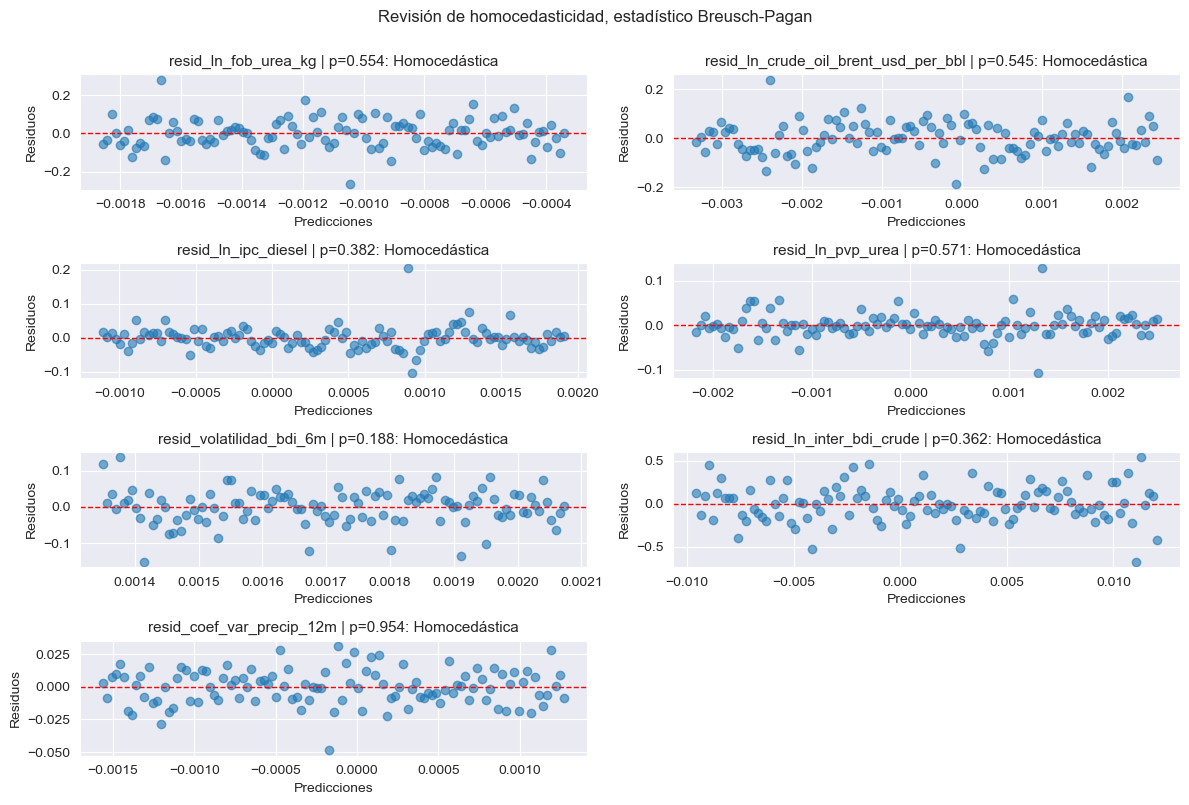

In [197]:
plot_homoscedasticity(residuos_vecm)

In [198]:
# hola mis negros